In [116]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

# Get data & split into train/test/validation sets

In [117]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

# Split into train / validation / test sets

In [118]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, stratify=label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)

# Create & Train Initial Model

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [119]:
def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

y_pred_real = rfc.predict(x_test)
bench_marks(y_test, y_pred_real)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.93      0.93      0.93        45

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120

[[72  3]
 [ 3 42]]
Accuracy: 0.95
Recall: 0.9333333333333333
Precision: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       107
           1       0.97      0.92      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

[[105   2]
 [  5  59]]
Accuracy: 0.9590643274853801
Recall: 0.921875
Precision: 0.9672131147540983


# Feature Selection
Determine importance of each feature, and use recursive feature elimination to determine how many of our features to keep. Then adjust our feature set.

In [120]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print(rfecv.n_features_)
# will keep these features
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.3, stratify=label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)

ConcavePointsWorst       0.191157
ConcavePoints            0.174686
Radius                   0.147818
RadiusWorst              0.120490
Concavity                0.049698
Compactness              0.038009
RadiusSE                 0.035373
ConcavityWorst           0.032440
CompactnessWorst         0.028449
TextureWorst             0.026872
ConcavePointsSE          0.021971
ConcavitySE              0.018729
Texture                  0.016718
FractalDimension         0.013894
SymmetryWorst            0.012733
FractalDimensionWorst    0.010163
SmoothnessWorst          0.010047
SymmetrySE               0.009213
FractalDimensionSE       0.008568
Symmetry                 0.007175
CompactnessSE            0.007019
SmoothnessSE             0.006677
TextureSE                0.006468
Smoothness               0.005636
dtype: float64
21
Index(['Radius', 'Texture', 'Compactness', 'Concavity', 'ConcavePoints',
       'FractalDimension', 'RadiusSE', 'TextureSE', 'CompactnessSE',
       'ConcavitySE', 'C

In [121]:
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

y_pred_real = rfc.predict(x_test)
bench_marks(y_test, y_pred_real)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97        75
           1       0.93      0.96      0.95        45

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120

[[72  3]
 [ 2 43]]
Accuracy: 0.9583333333333334
Recall: 0.9555555555555556
Precision: 0.9347826086956522
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       107
           1       0.94      1.00      0.97        64

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

[[103   4]
 [  0  64]]
Accuracy: 0.9766081871345029
Recall: 1.0
Precision: 0.9411764705882353


# Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration. Iterate by running this code while changing values in first box.

In [122]:
n_estimators = [500, 700, 1000] #Usually more is better and reduce overfitting, but higher computational cost and diminishing returns after ~128
max_depth = [5, 6, 7,8, 9, 10, 11, 12,13, 14, 15, 16, 17] # Increase leads to increase in variance and decrease in bias
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 7]#Increase leads to increase in bias and decrease in variance
bootstrap = [True, False]
criterion=['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap,
               'criterion': criterion}

In [123]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_

#ressults with validation set
y_pred = rfc.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print("\n")

#results with actual test set
y_real_pred = rfc.predict(x_test)
print("For actual test set we get:")
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')



Fitting 3 folds for each of 200 candidates, totalling 600 fits
RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=500)
Accuracy: 0.9416666666666667
Recall: 0.9555555555555556
Precision: 0.8958333333333334


For actual test set we get:
Accuracy: 0.9707602339181286
Recall: 0.984375
Precision: 0.9402985074626866


# Test for over/ underfitting

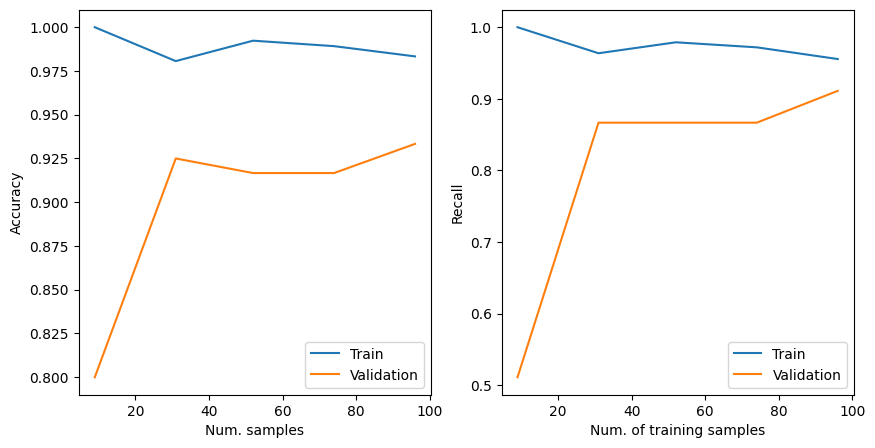

In [124]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_val, y=y_val, scoring='accuracy', cv=5)
train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_val, y=y_val, scoring='recall', cv=5)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []


for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Validation'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Validation'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

Could plot against test set, but best to do again validation as it shows us how our model changes.

The learning curve changes a lot each time. This may be because there isn't much relationship between the variables and label, but we used cross validation to get rid of this issue - another reason may be because our dataset is too small. There is a fairly large gap between my train and validation sets, so I increased the train/test/validation split as I feel the graph could trend towards a more accurate union between the two sets.

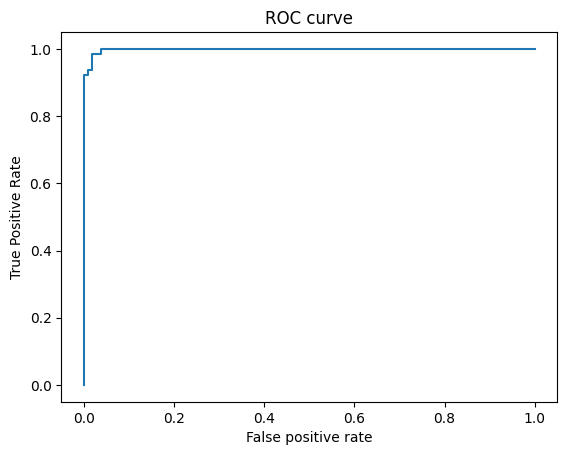

In [125]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()


We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.

In [126]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
y_pred = rfc.predict(x_test)  # Model classifications
accuracy = accuracy_score(y_test, y_pred)

print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model
